In this example we will use a normalizing flow as a variational posterior for a gravitational-wave population analysis on GWTC-3 data. `gwax` is fully compatible with [`gwpopulation`](https://colmtalbot.github.io/gwpopulation), from which you can use the likelihood as usual, making sure to use the JAX backend. From there, you just replace your favourite stochastic sampling algorithm with the variational inference training loop in `gwax`.

## Download GWTC-3 parameter-estimation samples and sensitivty injections

In [1]:
import os

In [2]:
if not os.path.exists('./o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_samples.hdf5'):
    if not os.path.exists('./analyses_PowerLawPeak.tar.gz'):
        !wget https://zenodo.org/records/11254021/files/analyses_PowerLawPeak.tar.gz
    !tar -xzvf analyses_PowerLawPeak.tar.gz
    !mv ./analyses/PowerLawPeak/o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_samples.hdf5 .
    !rm -r analyses

In [3]:
if not os.path.exists('./o1+o2+o3_bbhpop_real+semianalytic-LIGO-T2100377-v2.hdf5'):
    !wget https://zenodo.org/records/7890398/files/o1+o2+o3_bbhpop_real+semianalytic-LIGO-T2100377-v2.hdf5

In [4]:
ls

analyses_PowerLawPeak.tar.gz
o1+o2+o3_bbhpop_real+semianalytic-LIGO-T2100377-v2.hdf5
o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_samples.hdf5
variational-custom.ipynb
variational-simple.ipynb


## Imports

In [5]:
import numpy as np
import pandas
import h5py
import json
import matplotlib.pyplot as plt
from corner import corner

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp

import gwpopulation
gwpopulation.set_backend('jax')

In [7]:
jax.devices()

[cuda(id=0)]

## Load the data

In [8]:
def load_posteriors():
    posteriors = []
    
    with h5py.File(
        './o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_samples.hdf5', 'r',
    ) as f:

        samples = f['original']
        num_obs, num_samples = samples['a_1'].shape
        
        for n in range(num_obs):
            posterior = pandas.DataFrame()
            for par in samples:
                posterior[par] = samples[par][n, :]

            posteriors.append(posterior)
    
    return posteriors

In [9]:
def load_injections():
    cut_far = 1.0
    cut_snr = 10.0
    
    injections = {}
    
    with h5py.File(
        './o1+o2+o3_bbhpop_real+semianalytic-LIGO-T2100377-v2.hdf5', 'r',
    ) as f:
        samples = f['injections']
    
        ifars = [
            samples[par][:] for par in samples.keys()
            if ('ifar' in par) and ('cwb' not in par)
            ]
        ifar = np.max(ifars, axis=0)
        snr = samples['optimal_snr_net'][:]
        runs = samples['name'][:].astype(str)
        found = np.where(runs == 'o3', ifar > 1/cut_far, snr > cut_snr)
    
        mass_1 = samples['mass1_source'][:][found]
        mass_2 = samples['mass2_source'][:][found]
        spin1x = samples['spin1x'][:][found]
        spin1y = samples['spin1y'][:][found]
        spin1z = samples['spin1z'][:][found]
        spin2x = samples['spin2x'][:][found]
        spin2y = samples['spin2y'][:][found]
        spin2z = samples['spin2z'][:][found]
        redshift = samples['redshift'][:][found]
    
        mass_ratio = mass_2 / mass_1
        a_1 = (spin1x**2 + spin1y**2 + spin1z**2)**.5
        a_2 = (spin2x**2 + spin2y**2 + spin2z**2)**.5
        cos_tilt_1 = spin1z / a_1
        cos_tilt_2 = spin2z / a_2
    
        injections['mass_1'] = mass_1
        injections['mass_ratio'] = mass_ratio
        injections['a_1'] = a_1
        injections['a_2'] = a_2
        injections['cos_tilt_1'] = cos_tilt_1
        injections['cos_tilt_2'] = cos_tilt_2
        injections['redshift'] = redshift
    
        prior = samples['sampling_pdf'][:][found]
        prior *= mass_1 * 4 * np.pi**2 * a_1**2 * a_2**2
        injections['prior'] = prior
    
        dodgy = injections['redshift'] > 1.9
        for par in injections:
            injections[par] = injections[par][~dodgy]
    
        injections['total_generated'] = samples.attrs['total_generated']
    
    for par in injections:
        injections[par] = jnp.array(injections[par])
    
    return injections

In [10]:
posteriors = load_posteriors()
injections = load_injections()

2024-07-17 13:01:38.701089: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Define the population model

This is exactly as you normally do with gwpopulation.

In [11]:
from gwpopulation.models.mass import SinglePeakSmoothedMassDistribution
from gwpopulation.models.spin import iid_spin
from gwpopulation.models.redshift import PowerLawRedshift
from gwpopulation.experimental.jax import NonCachingModel

In [12]:
def spin_model(dataset, xi_spin, sigma_spin, alpha_chi, beta_chi):
    amax = 1.0
    return iid_spin(dataset, xi_spin, sigma_spin, amax, alpha_chi, beta_chi)

In [13]:
def make_model():
    models = [
        SinglePeakSmoothedMassDistribution(),
        spin_model,
        PowerLawRedshift(cosmo_model = 'Planck15'),
    ]
    return NonCachingModel(models)

## Defined the population likelihood

This is exactly as you normally do with gwpopulation.

In [14]:
from gwpopulation.vt import ResamplingVT
from gwpopulation.hyperpe import HyperparameterLikelihood

In [15]:
selection_function = ResamplingVT(
    model = make_model(),
    data = injections,
    n_events = len(posteriors),
    marginalize_uncertainty = False,
    enforce_convergence = False,
)

In [16]:
likelihood = HyperparameterLikelihood(
    posteriors = posteriors,
    hyper_prior = make_model(),
    selection_function = selection_function,
    maximum_uncertainty = jnp.inf,
)

## Variational inference

In [17]:
from gwax.variational import trainer

Currently only univariate uniform priors are possible. Below we set the prior bounds on the parameters of the population model.

In [18]:
prior_bounds = dict(
    alpha = [-4, 12],
    beta = [-2, 7],
    mmin = [0, 6.5],
    mmax = [65, 100],
    lam = [0, 1],
    mpp = [20, 50],
    sigpp = [1, 10],
    delta_m = [0, 10],
    lamb = [-6, 6],
    alpha_chi = [1, 10],
    beta_chi = [1, 10],
    xi_spin = [0, 1],
    sigma_spin = [0.1, 4],
)

Train the variational posterior, given by a default normalizing flow model. The prior bounds are used to constrain the support of the posterior. Compilation will take a few seconds before the loop runs.

In [19]:
import time

In [20]:
t0 = time.time()

flow, losses = trainer(
    key = jax.random.PRNGKey(0),
    prior_bounds = prior_bounds,
    likelihood = likelihood,
    steps = 10_000,
    learning_rate = 1e-2,
)

dt = time.time() - t0
print(f'Run time including JIT compilation: {dt:.1f} seconds')

  0%|          | 0/10000 [00:00<?, ?it/s]

Run time including JIT compilation: 45.4 seconds


You can use the evolution of the loss over training steps to check the variational posterior has converged.

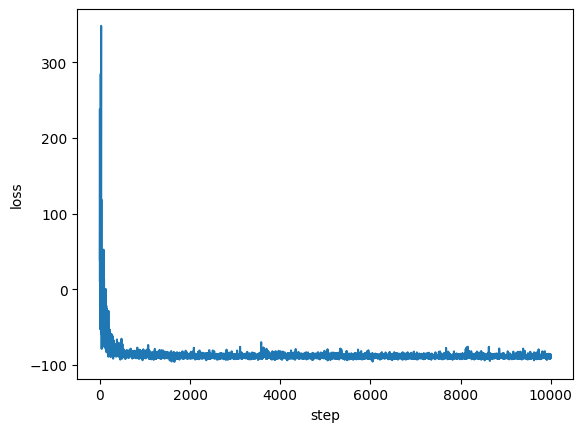

In [21]:
plt.plot(losses)
plt.xlabel('step')
plt.ylabel('loss');

## Posterior for parameters of population model

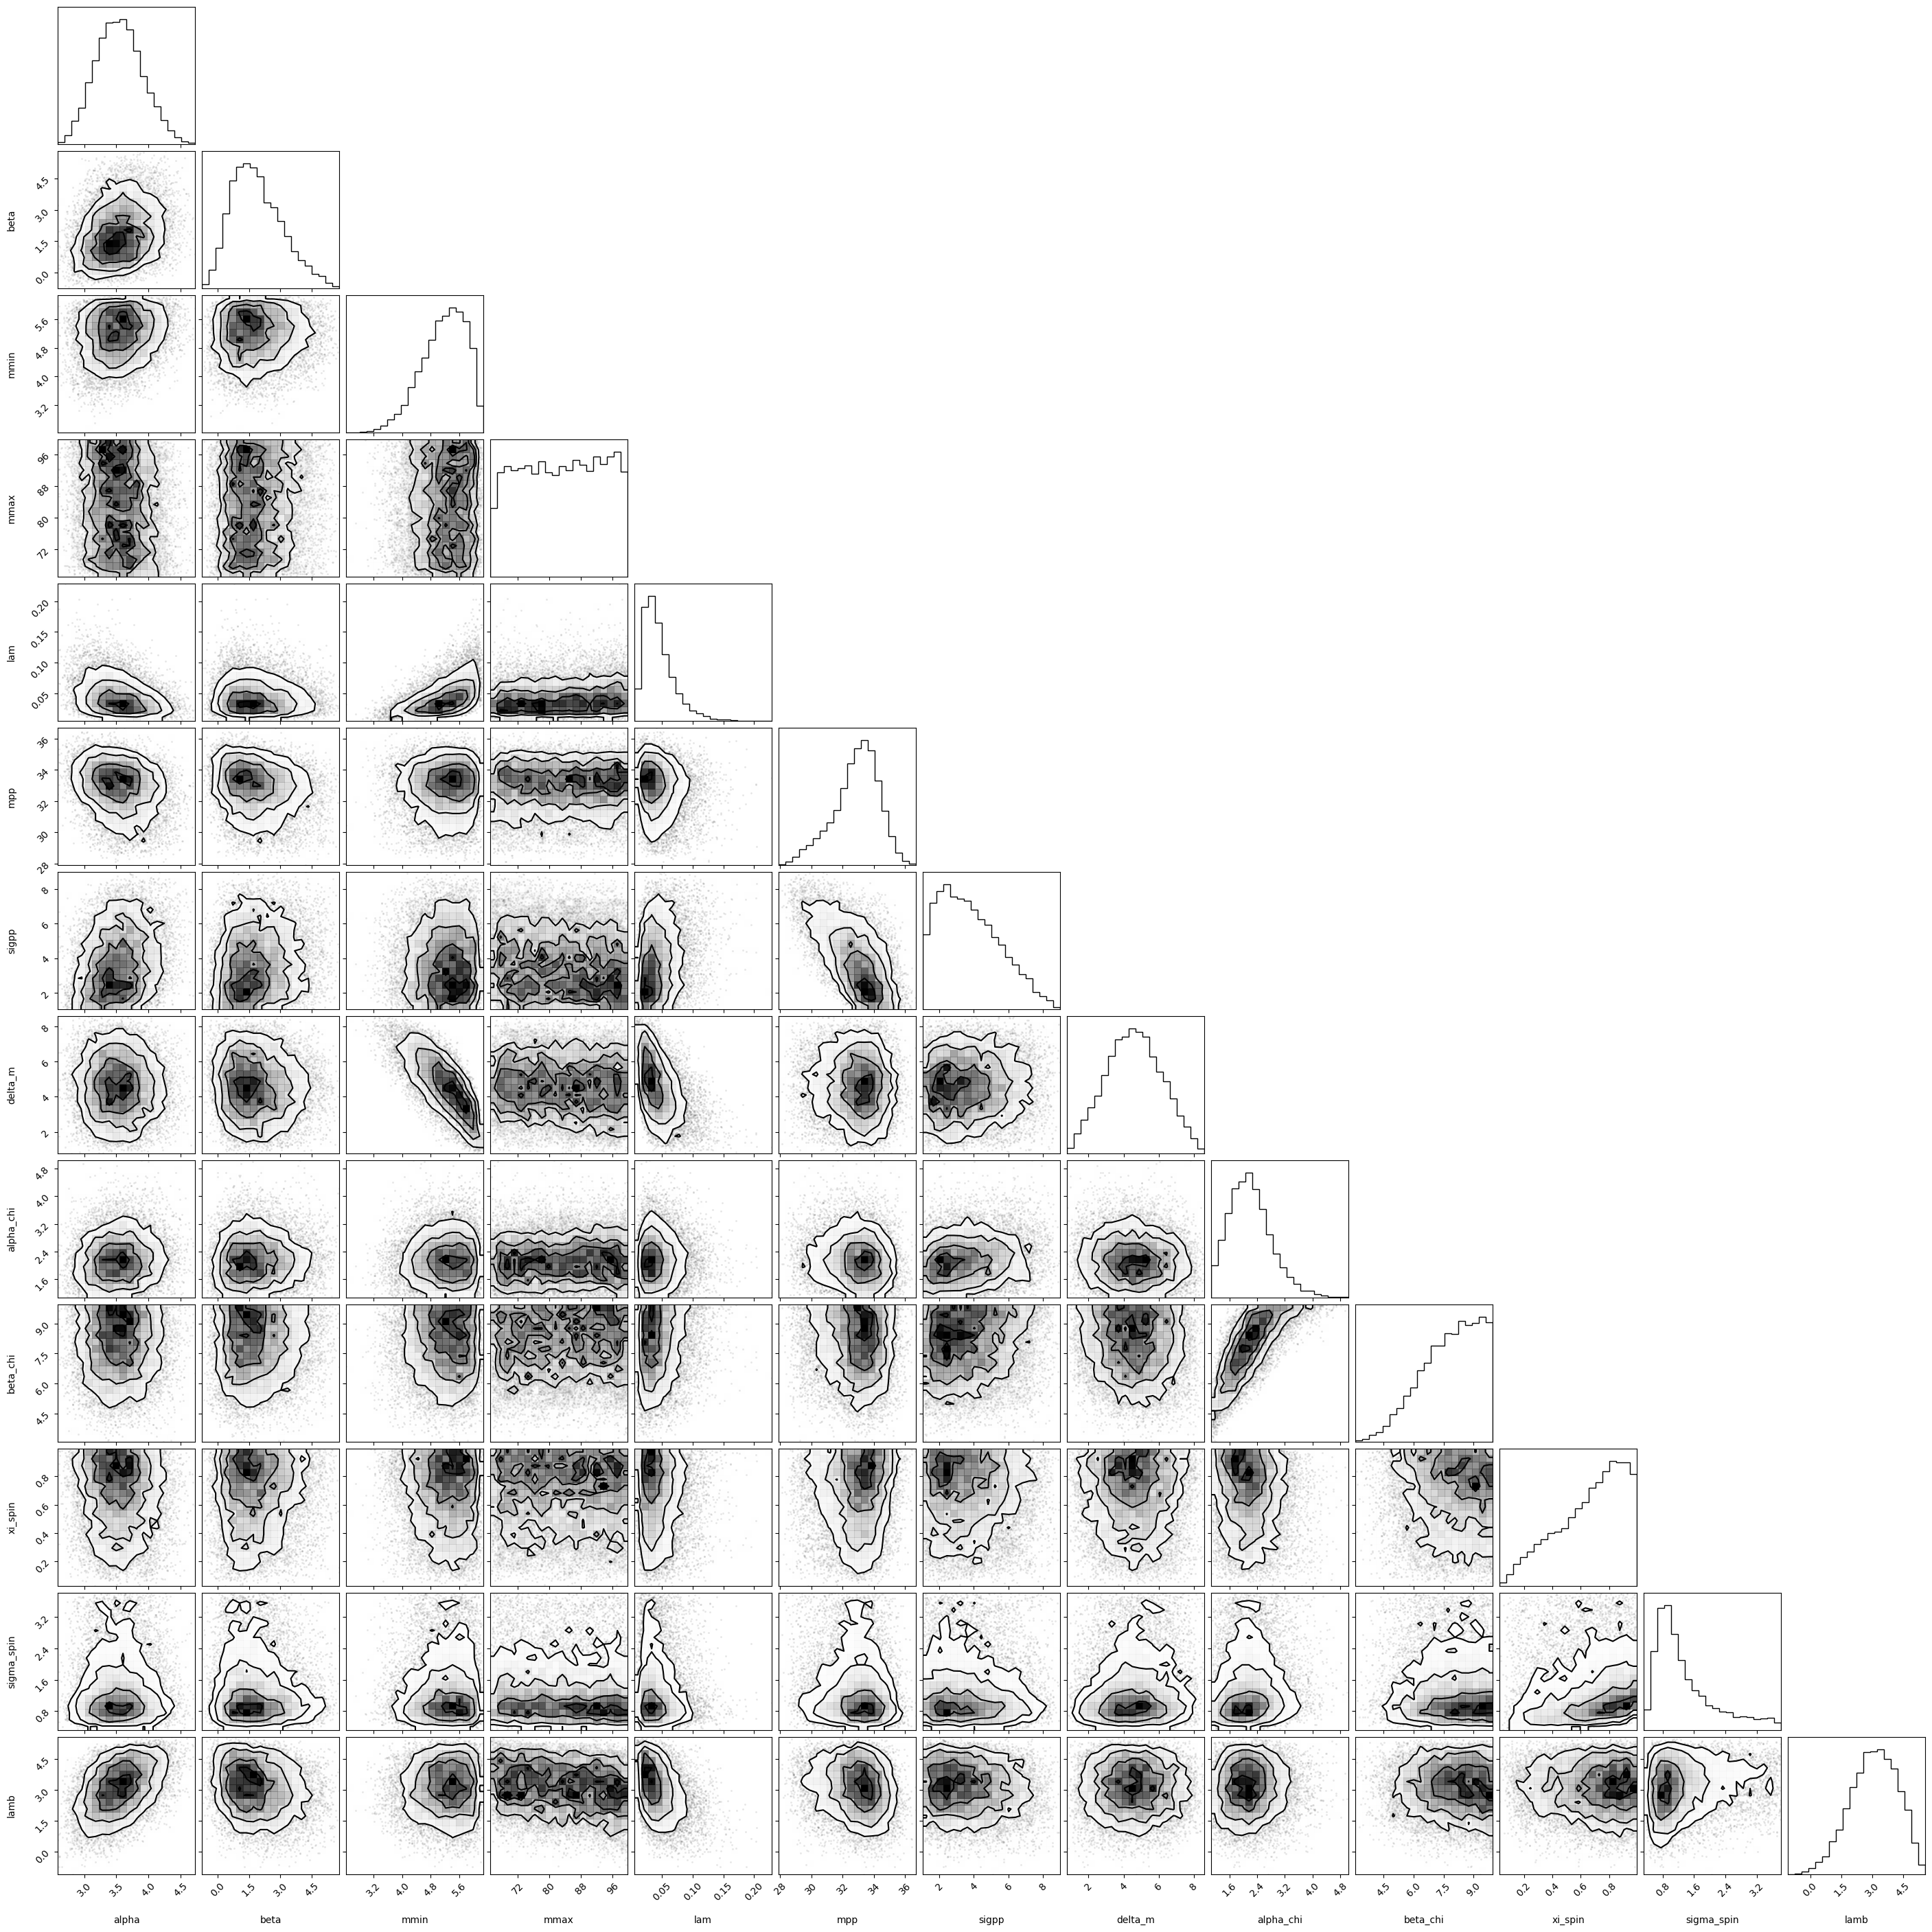

In [22]:
samples = flow.sample(jax.random.PRNGKey(1), (10_000,))
corner(np.array(samples), labels = list(prior_bounds));

## Predictive distributions

Evaluate the population model at a set of posterior samples to visualize the constrains on the population-level parameter distributions.

In [23]:
m1 = jnp.linspace(2, 100, 1_000)
m1_model = SinglePeakSmoothedMassDistribution()
m1_pdf = lambda parameters: m1_model.p_m1(
    dataset = dict(mass_1 = m1),
    alpha = parameters['alpha'],
    mmin = parameters['mmin'],
    mmax = parameters['mmax'],
    lam = parameters['lam'],
    mpp = parameters['mpp'],
    sigpp = parameters['sigpp'],
)

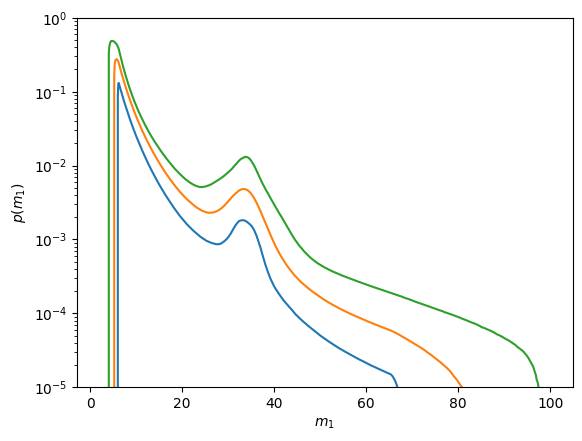

In [24]:
parameters = dict(zip(prior_bounds, samples.T))
pdfs = jax.vmap(m1_pdf)(parameters)
plt.plot(m1, np.quantile(pdfs, (0.05, 0.5, 0.95), axis = 0).T)
plt.semilogy()
plt.ylim(1e-5, 1e0)
plt.xlabel('$m_1$')
plt.ylabel('$p(m_1)$');

## Importance sampling

In [25]:
from gwax.variational import importance

In [27]:
stats = importance(
    key = jax.random.PRNGKey(2),
    prior_bounds = prior_bounds,
    likelihood = likelihood,
    flow = flow,
    batch_size = 10_000,
)

In [28]:
stats.keys()

dict_keys(['samples', 'weights', 'log_evidence', 'log_evidence_variance', 'efficiency'])

In [29]:
print(
    f"log(evidence) = {stats['log_evidence']} "
    f"+/- {stats['log_evidence_variance'] ** 0.5}"
)
print(f"sample efficiency = {stats['efficiency'] * 100} %")

log(evidence) = 90.00513034576261 +/- 0.001169057591152596
sample efficiency = 7.879863033574072 %


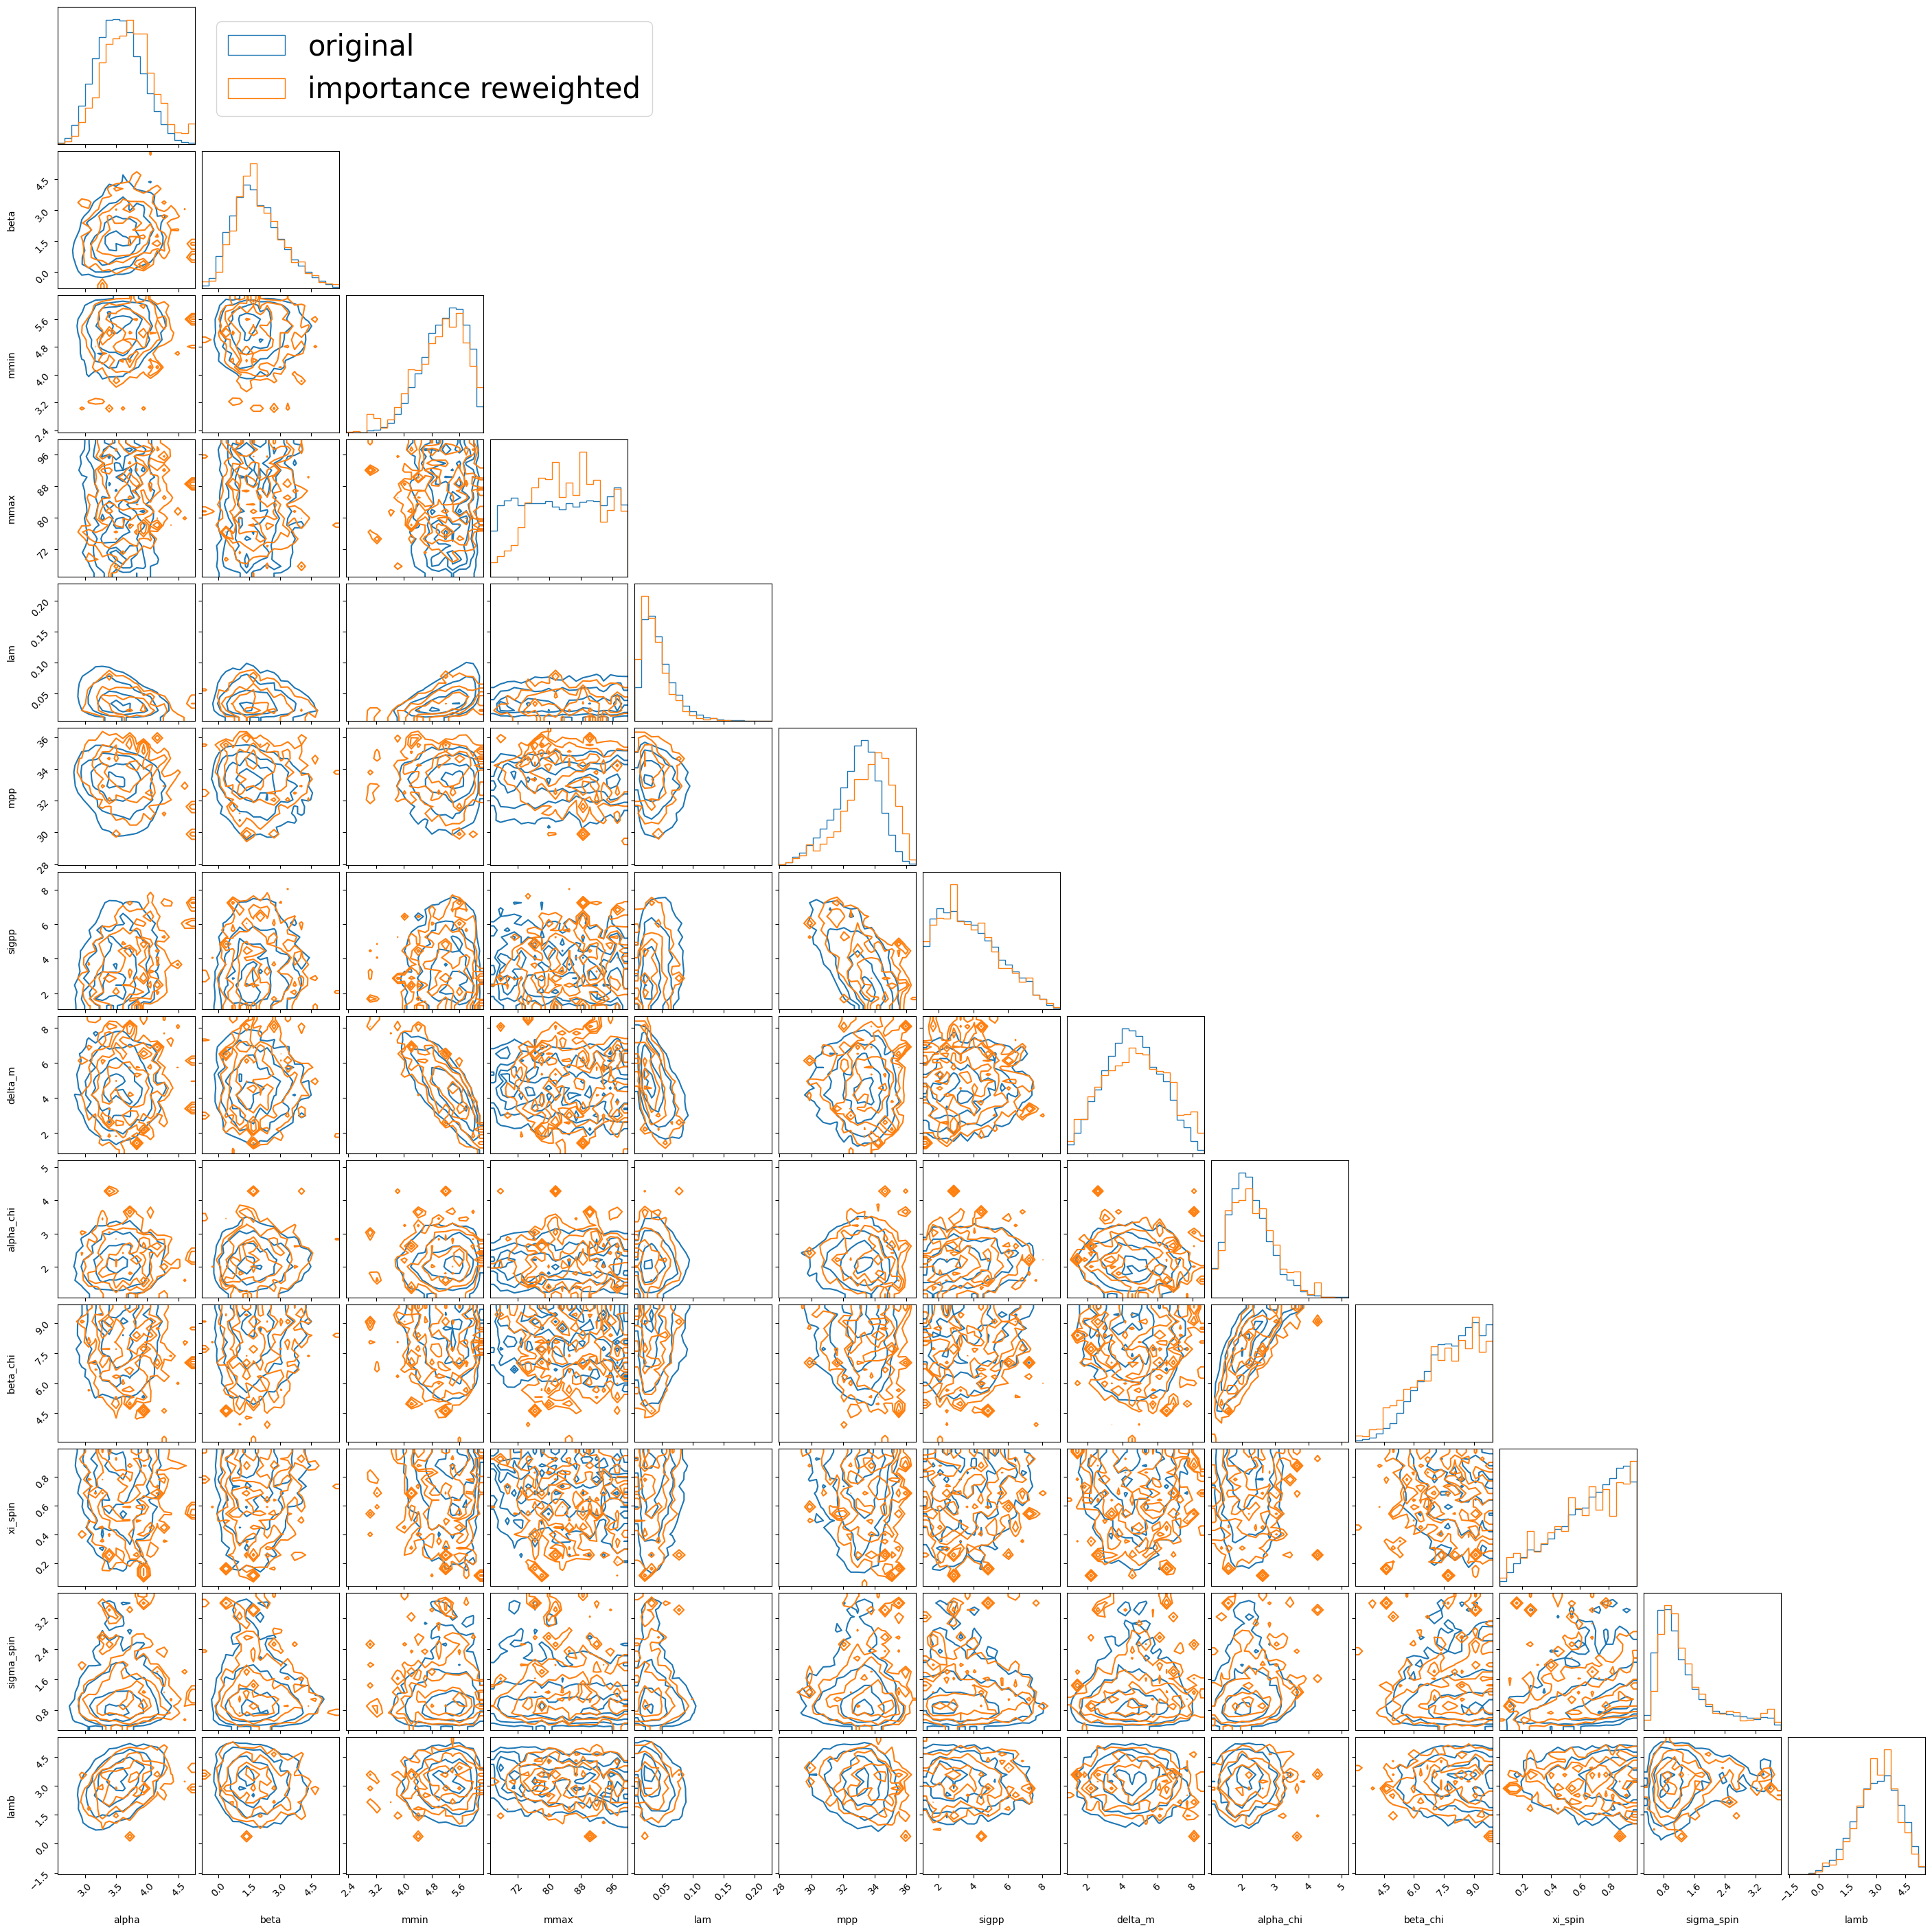

In [34]:
fig = None
for i, weights in enumerate((None, stats['weights'])):
    color = plt.get_cmap('tab10')(i)
    fig = corner(
        np.array(stats['samples']),
        weights = weights,
        labels = list(prior_bounds),
        fig = fig,
        plot_datapoints = False,
        plot_density = False,
        plot_contours = True,
        fill_contours = False,
        no_fill_contours = True,
        hist_kwargs = dict(density = True, color = color),
        contour_kwargs = dict(colors = [color]),
    )

handles = fig.axes[0].patches
labels = 'original', 'importance reweighted'
fig.axes[1].legend(handles, labels, loc = 'upper left', fontsize = 30);